# Modeliranje i dekompozicija podataka

Iako algoritmi za automatsko modeliranje kao što je `auto_arima` mogu proizvesti modele koji predviđaju sa zadovoljavajućom preciznosti, važno je razumjeti parametre odabranog modela i usporediti ih sa stvarnim svojstvima odabranog skupa podataka.


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from scipy import stats

warnings.filterwarnings("ignore")
sns.set_theme()

## Učitavanje i proširivanje podataka s ciljnom varijablom

Podatke razdvajamo u više skupova ovisno o kojem se hotelu radi (`hotel_id`) jer je očekivano da će se podaci za svaki od hotela ponašati različito i da će se predviđanje popunjenosti raditi za svaki hotel pojedinačno.

Ciljna varijabla je ukupan broj gostiju u nekom hotelu u nekom vremenskom periodu, gdje smo odredili da vremenski period može biti:
- dan
- tjedan
- mjesec
- godina

Čišćenje i proširivanje podataka radimo na način koji je opisan u bilježnici `ARIMA_occupancy_prediction.ipynb`.

In [2]:
data = pd.read_parquet('../data/raw/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [3]:
# Osnovno čišćenje podataka
data = data[~(data['zemlja_gosta']=='0')]
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)

# Ukupan broj gostiju po zapisu
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']

# Duljina boravka
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days

# Rezervacije bez gostiju
data = data[data['ukupno_gostiju'] != 0]

# Otkazane rezervacije
data = data[~data['datum_otkazivanja_rezervacije'].notna()]
data = data.reset_index(drop=True)

# Razdvoji podatke iz različitih hotela
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

print(f"Resort ima {len(dataResort)} zapisa")
print(f"City ima {len(dataCity)} zapisa")

Resort ima 28506 zapisa
City ima 46047 zapisa


In [4]:
# Ciljne varijable - hotel 0
NumberOfGuestsResort = dataResort[['datum_dolaska', 'ukupno_gostiju']]

NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()

NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()

NumberOfGuestsMonthlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort = NumberOfGuestsMonthlyResort.resample('m').sum().to_frame()

NumberOfGuestsYearlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsYearlyResort = NumberOfGuestsYearlyResort.resample('y').sum().to_frame()

NumberOfGuestsMonthlyResort.head()

,ukupno_gostiju
datum_dolaska,
2015-07-31,2300
2015-08-31,2318
2015-09-30,2013
2015-10-31,2108
2015-11-30,1534


In [5]:
# Ciljne varijable - hotel 1
NumberOfGuestsCity = dataCity[['datum_dolaska', 'ukupno_gostiju']]

NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()

NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('w').sum().to_frame()

NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity.resample('m').sum().to_frame()

NumberOfGuestsYearlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsYearlyCity = NumberOfGuestsYearlyCity.resample('y').sum().to_frame()

NumberOfGuestsMonthlyCity.head()

,ukupno_gostiju
datum_dolaska,
2015-01-31,206
2015-02-28,0
2015-03-31,0
2015-04-30,0
2015-05-31,1072


## Modeliranje

Model ARIMA ugađamo prema postupku navedenom u [1, Pog. 8.7]:
1. Iscrtavanje vremenskog niza i identifikacija anomalija
2. Stabilizacija varijance (ako već nije stabilna)
3. Diferenciranje podataka do stacionarnosti
4. Analiza autokorelacijske (ACF) i parcijalne autokorelacijske (PACF) funkcije
    - provjeriti prikladnost i sezonalnih i nesezonalnih AR(p) i MA(q) modela
    - odrediti sezonalni period $m$
5. Usporedba odabranog modela s njegovim varijacijama na osnovu AIC_c kriterija
6. Ponavljaj korake 4. i 5. dok reziduali najboljeg modela ne odgovaraju bijelom šumu
7. Računanje prognoze

### Korak 1: Iscrtavanje podataka

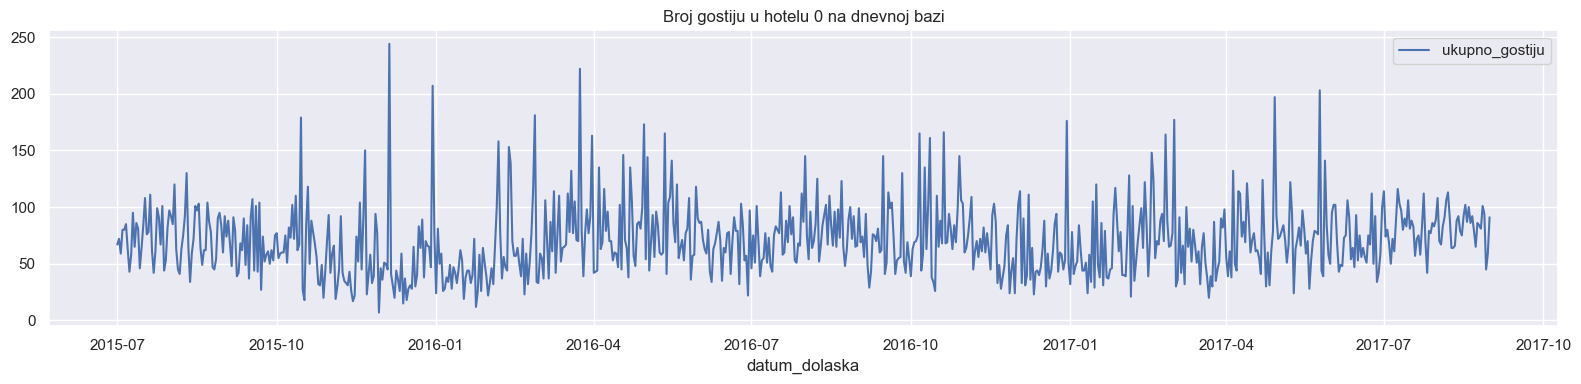

In [6]:
plt.figure(figsize=(16, 4))
ax = sns.lineplot(NumberOfGuestsDailyResort)
ax.set_title("Broj gostiju u hotelu 0 na dnevnoj bazi")
plt.tight_layout()
plt.show()

Iako ne uočavamo nagle promjene u trendu, vidljivi su poneki veći skokovi u vrijednostima (početak prosinca 2015.) koji se mogu pripisati popularnim periodima godine za odmor (predbožićno razdoblje).

### Korak 2: Stabilizacija varijance

Kao što smo prethodno naveli, broj gostiju za pojedine datume znatno se razlikuje od susjednih datuma, pa naslućujemo da varijanca podataka nije stabilna. 

U slučaju da se podaci mogu modelirati multiplikativnim modelom, varijanca podataka može se stabilizirati logaritmiranjem [1]. Inače je potrebno primijeniti drugačije transformacije.

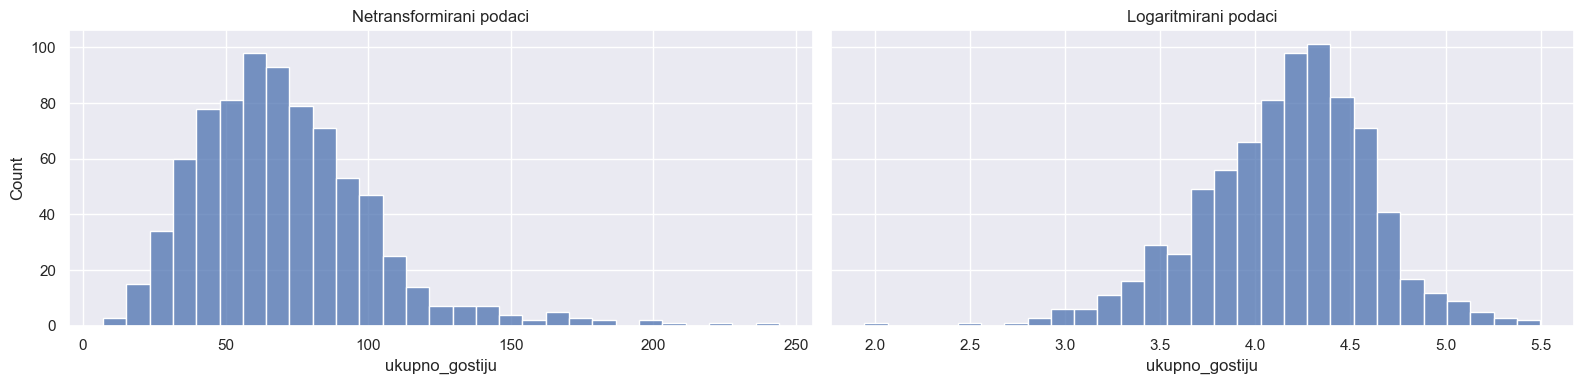

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4), sharey=True)

sns.histplot(NumberOfGuestsDailyResort["ukupno_gostiju"], ax=ax1)
ax1.set_title("Netransformirani podaci")
sns.histplot(np.log(NumberOfGuestsDailyResort["ukupno_gostiju"]), ax=ax2)
ax2.set_title("Logaritmirani podaci")

plt.tight_layout()
plt.show()

Transformacijama koje stabilziraju varijancu smanjujemo međuovisnost varijance i očekivanja [2]. Prema tome, podaci sa stabilnom varijancom trebali bi biti normalno distribuirani.

Logaritmiranjem "premašujemo" normalnu razdiobu i oba histograma ne odgovaraju normalnoj razdiobi, pa podatke ne možemo dekomponirati niti aditivnim niti multiplikativnim modelom, već nečime između. Takve podatke možemo svesti na normalnu razdiobu jednoparametarskom **Box-Cox transformacijom**:
$$
\dfrac{y^{\lambda} - 1}{\lambda}, \qquad 0 \lt y \lt 1
$$
gdje $\lambda = 0$ odgovara multiplikativnoj, a $\lambda = 1$ aditivnoj dekompoziciji [1].

Metodom `scipy.stats.boxcox` možemo pronaći $\lambda$ za koji je log-izglednost minimalna, a razdioba najsličnija normalnoj.

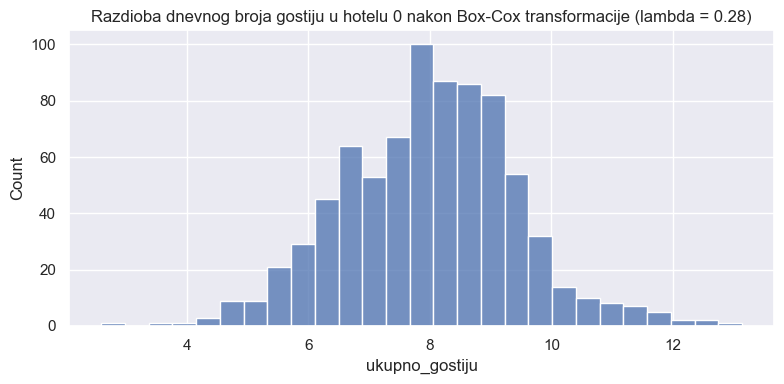

In [8]:
transformed_daily_data = NumberOfGuestsDailyResort.copy()

transformed, lmbda = stats.boxcox(NumberOfGuestsDailyResort["ukupno_gostiju"])
transformed_daily_data["ukupno_gostiju"] = transformed

plt.figure(figsize=(8,4))
ax = sns.histplot(transformed_daily_data["ukupno_gostiju"])
ax.set_title(f"Razdioba dnevnog broja gostiju u hotelu 0 nakon Box-Cox transformacije (lambda = {lmbda:.2f})")
plt.tight_layout()
plt.show()

Dakle, promjenom Box-Cox transformacije s parametrom $\lambda = 0.28$ stabilizirali smo varijancu podataka.

### Korak 3: Diferenciranje podataka do stacionarnosti

Svojstva stacionarnog vremenskog niza ne ovise o vremenu kada je taj niz promatran, zbog čega se u tim podacima u dužem periodu ne mogu uočiti nikakvi uzorci koji se mogu predvidjeti. Takvi nizovi nemaju izražen ni trend ni sezonalnost, ali mogu imati ciklička svojstva jer su u pravilu ciklusi promjenjive duljine. [1]

Dok transformacijama iz prethodnog koraka možemo stabilizirati varijancu vremenskog, diferenciranjem (računanjem razlika između susjednih vrijednosti) možemo stabilizirati njegovo očekivanje. Drugim riječima, iako je neki niz nestacionaran, razlike između susjednih vrijednosti mogu biti stacionarne. 

Sezonalnim diferenciranjem možemo smanjiti utjecaj sezonalnosti na vremenski niz. Za $m$ izmjerenih vrijednosti u jednom periodu sezonalnosti, sezonalne diferencijale u trenutku $t$ računamo formulom
$$
y_t' = y_t - y_{t-m}
$$

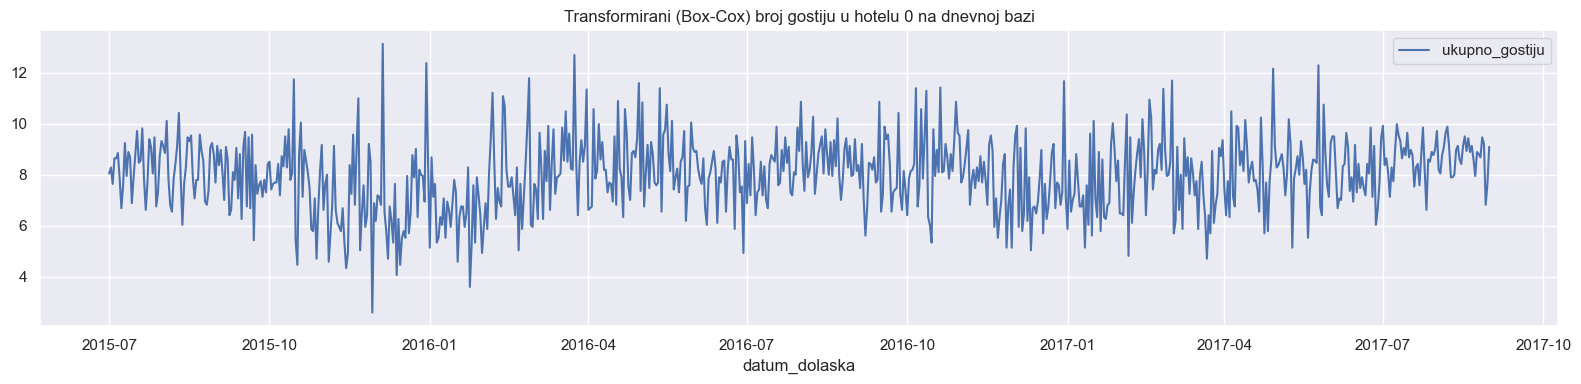

In [9]:
plt.figure(figsize=(16, 4))
ax = sns.lineplot(transformed_daily_data)
ax.set_title("Transformirani (Box-Cox) broj gostiju u hotelu 0 na dnevnoj bazi")
plt.tight_layout()
plt.show()

Jasno je vidljiv negativan trend u razdoblju oko siječnja 2016., ali i sezonalnost. Autori u [1] za podatke s izraženim sezonalnim svojstvima preporučuju prvo provesti sezonalno diferenciranje jer prvi diferencijali neće ukloniti sezonalnost, ali samo sezonalni diferencijalni mogu svesti vremenski niz na stacionarni.

Kako bismo se uvjerili u prisutnost sezonalnosti i da je niz nestacionaran možemo iscrtati njegovu autokorelacijsku funkciju [1].

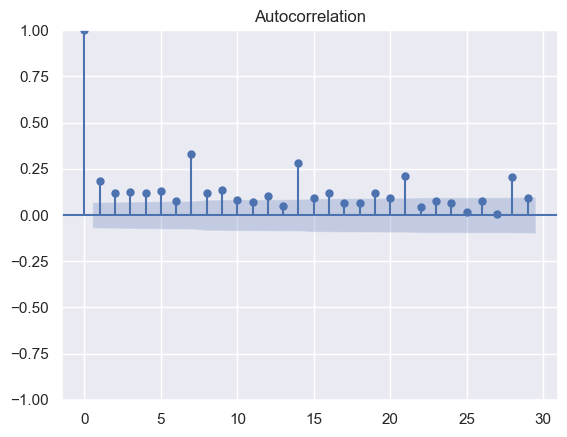

In [10]:
_ = plot_acf(transformed_daily_data["ukupno_gostiju"], alpha=0.05) 

Uočavamo vrijednosti koje nisu blizu nule (pomaci 1-7), dakle niz sigurno nije stacionaran.

Iako period sezonalnosti možemo odrediti izravno iz podataka, iz ACF grafa jasno vidimo da se vrijednosti izvan intervala pouzdanosti ponavljaju svako sedam pomaka. Dakle, potrebno je sezonalno diferencirati podatke s periodom $m=7$.

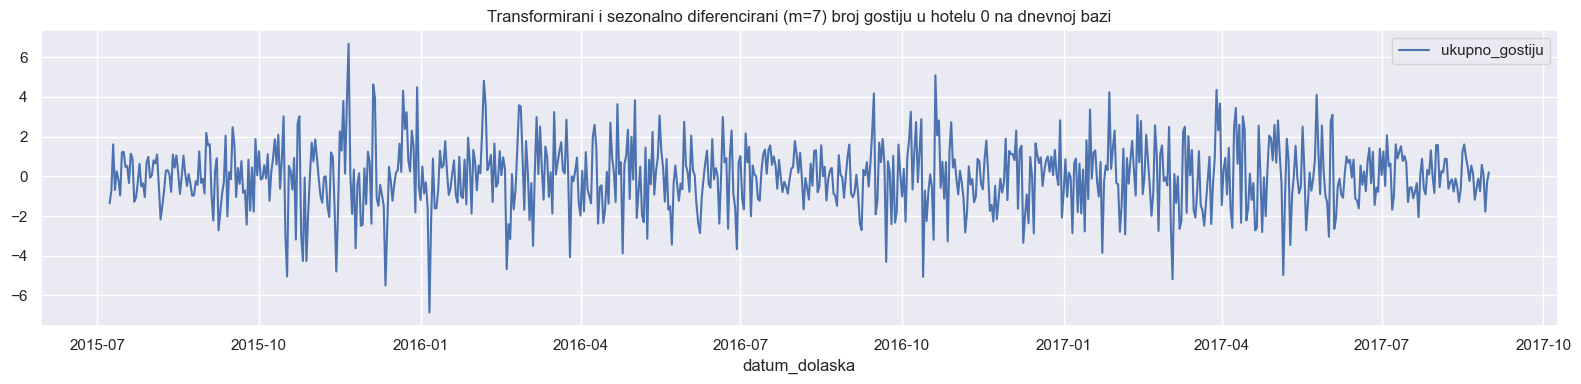

In [11]:
transformed_sdiff_daily_data = transformed_daily_data.diff(periods=7)[7:] # izbaci NaN
plt.figure(figsize=(16, 4))
ax = sns.lineplot(transformed_sdiff_daily_data)
ax.set_title("Transformirani i sezonalno diferencirani (m=7) broj gostiju u hotelu 0 na dnevnoj bazi")
plt.tight_layout()
plt.show()

Iz grafa vidimo da smo jednim sezonalnim diferenciranjem uklonili utjecaje i trenda i sezonalnosti. U slučaju da je dobiveni vremenski niz zaista stacionaran, očekujemo da će autokorelacijska funkcija vrlo brzo pasti u nulu.

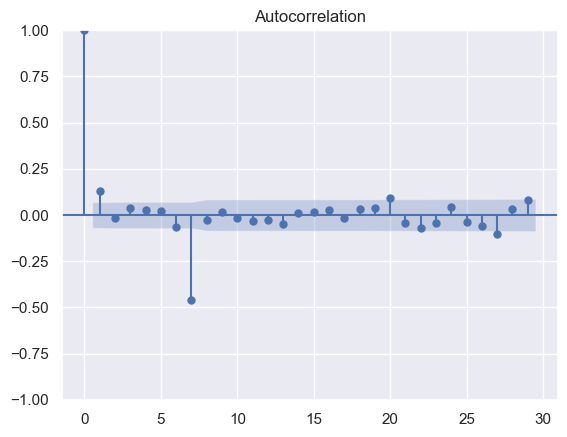

In [12]:
_ = plot_acf(transformed_sdiff_daily_data["ukupno_gostiju"], alpha=0.05)

### Korak 4: Procjena parametara modela pomoću ACF i PACF grafova

Za modeliranje vremenskog niza koristit ćemo sezonalni model ARIMA:

$$
ARIMA \; (p,d,q) \; (P,D,Q)_m
$$

Gdje su $p$, $d$ i $q$ parametri nesezonalnog modela ARIMA, $P$, $D$ i $Q$ odgovarajući sezonalni parametri, a $m$ veličina jednog perioda sezonalnosti.
- $p, P$ - red autoregresijskog dijela
- $d, D$ - stupanj (sezonalnog) diferenciranja
- $q, Q$ - red pomičnog prosjeka

Ove parametre možemo izravno procijeniti iz dijagrama autokorelacijske funkcije (ACF) i parcijalne autokorelacijske funkcije (PACF). Autokorelacijska funkcija mjeri odnos između elemenata niza $y_t$ i $y_{t-h}$ za različite vrijednosti pomaka $h$, dok parcijalna autokorelacijska funkcija mjeri odnose između $y_t$ i $y_{t-h}$ nakon uklanjanja utjecaja "međupomaka" $1, 2, 3, \dots, k-1$ [1].


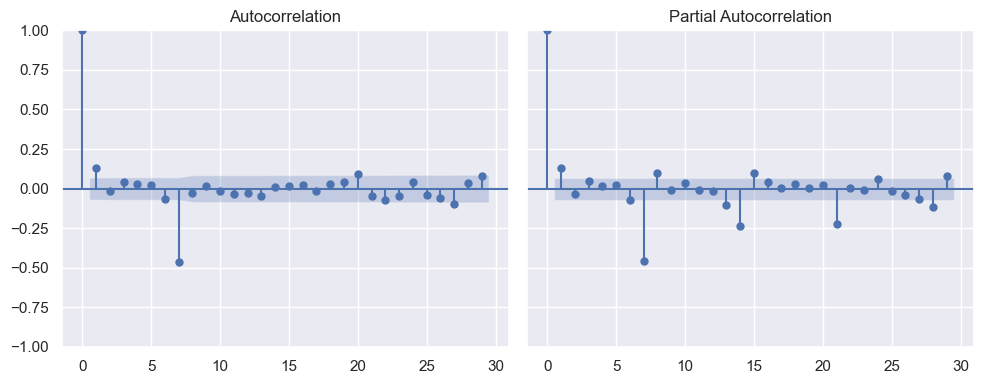

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)

plot_acf(transformed_sdiff_daily_data["ukupno_gostiju"], alpha=0.05, ax=ax1)
plot_pacf(transformed_sdiff_daily_data["ukupno_gostiju"], alpha=0.05, ax=ax2)

plt.tight_layout()
plt.show()

> TODO: Analiza grafova